# Session 7 - Tree-based Methods

## Contents

- [The Basics of Decision Trees](#The-Basics-of-Decision-Trees)
- [Bagging, Random Forests, Boosting](#Bagging,-Random-Forests,-Boosting)

## Labs

- [Decision Trees](#Lab-1:-Decision-Trees)

In [339]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import pydot
from IPython.display import Image
from six import StringIO  

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error

In [64]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## The Basics of Decision Trees

Decision trees involve stratifying or segmenting the predictor space into a number of simple regions. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods.

### Regression Trees

For this session we will consider the `Hitters` dataset. It consists in individual level data of baseball players. In our applications, we are interested in predicting the players `Salary`.

In [3]:
# Load the data
hitters = pd.read_csv('data/Hitters.csv').dropna()
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In particular, we are interested in looking how the number of `Hits` and the `Years` of experience predict the salary.

In [4]:
# Get Features
features = ['Years', 'Hits']
X = hitters[features].values
y = np.log(hitters.Salary.values)

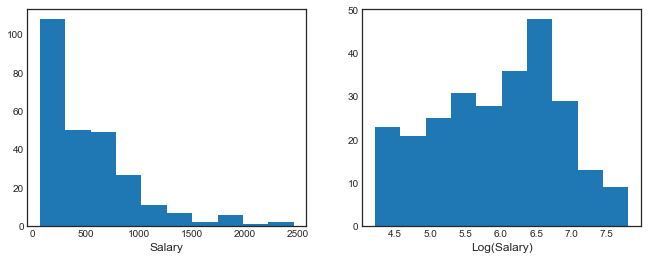

In [5]:
# Plot salary distribution
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(hitters.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

We fit a regression three with 3 leaf nodes.

In [7]:
# Fit regression tree
tree = DecisionTreeRegressor(max_leaf_nodes=3)
tree.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

We are now going to plot the results visually. The biggest avantage of trees is interpretability.

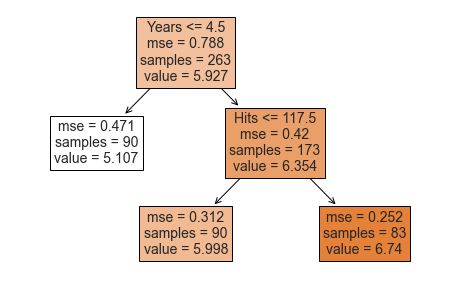

In [8]:
# Figure 8.1
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 8.1');

# Plot tree
plot_tree(tree, filled=True, feature_names=features, fontsize=14, ax=ax);

The tree consists of a series of splitting rules, starting at the top of the tree. The top split assigns observations having `Years`<4.5 to the left branch.1 The predicted salary for these players is given by the mean response value for the players in the data set with `Years`<4.5. For such players, the mean log salary is 5.107, and so we make a prediction of 5.107 thousands of dollars, i.e. $165,174, for these players. Players with `Years`>=4.5 are assigned to the right branch, and then that group is further subdivided by `Hits`. 

Overall, the tree stratifies or segments the players into three regions of predictor space:
1. players who have played for four or fewer years
2. players who have played for five or more years and who made fewer than 118 hits last year, and
3. players who have played for five or more years and who made at least 118 hits last year. 

These three regions can be written as 
1. **R1** = {X | `Years`<4.5}
2. **R2** = {X | `Years`>=4.5, `Hits`<117.5}, and 
3. **R3** = {X | `Years`>=4.5, `Hits`>=117.5}. 

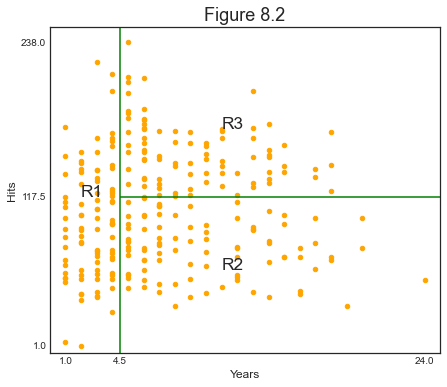

In [9]:
# Figure 8.2
hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.title('Figure 8.2')
plt.xlim(0,25); plt.ylim(ymin=-5);
plt.xticks([1, 4.5, 24]); plt.yticks([1, 117.5, 238]);

# Split lines
plt.vlines(4.5, ymin=-5, ymax=250, color='g')
plt.hlines(117.5, xmin=4.5, xmax=25, color='g')

# Regions
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

#### Building a tree

There are two main steps in the construction of a tree:

1. We divide the predictor space—that is, the set of possible values for $X_1, X_2, ... , X_p$ into $J$ distinct and non-overlapping regions, $R_1,R_2,...,R_J$.
2. For every observation that falls into the region $R_j$ , we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

The second step is easy. But how does one construct the regions? Our purpose is to minimize the Sum of Squared Residuals, across the different regions:

$$
\sum_{j=1}^{J} \sum_{i \in R_{j}}\left(y_{i}-\hat{y}_{R_{j}}\right)^{2}
$$

Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into $J$ boxes. For this reason, we take a **top-down**, **greedy** approach that is known as *recursive binary splitting*. The approach is top-down because it begins at the top of the tree (at which point all observations belong to a single region) and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step.

In practice, the method is the following:

1. we select the predictor $X_j$
2. we select the cutpoint $s$ such that splitting the predictor space into the regions $\{X|X_j < s\}$ and $\{X|X_j \geq s\}$ leads to the greatest possible reduction in RSS
3. we repeat (1)-(2) for all predictors $X_1, ... , X_p$, i.e. we solve

$$
\arg \min_{j,s} \ \sum_{i: x_{i} \in \{X|X_j < s\}}\left(y_{i}-\hat{y}_i\right)^{2}+\sum_{i: x_{i} \in \{X|X_j \geq s\}}\left(y_{i}-\hat{y}_i\right)^{2}
$$

4. we choose the predictor and cutpoint such that the resulting tree has the lowest RSS
6. we keep repeating (1)-(4) until a certain condition is met. However, after the first iteration we also have to pick which region to split which adds a further dimension to optimize over.

#### Pruning

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits might lead to lower variance and better interpretation at the cost of a little bias. 

One possible alternative to the process described above is to build the tree only so long as the decrease in the RSS due to each split exceeds some (high) threshold.

This strategy will result in smaller trees, but is too short-sighted since a seemingly worthless split early on in the tree might be followed by a very good split—that is, a split that leads to a large reduction in RSS later on.

We can use cross-validation to pick the optimal tree length.

In [120]:
def cross_validation(X, y, model, parameters):
    
    # Init scores
    scores = np.zeros((len(parameters),3))
    
    # Loop over all parameters
    for k,param in enumerate(parameters):
        
        # Loop over splits
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        m = model(param).fit(X_train, y_train)
        scores[k,0] = mean_squared_error(m.predict(X_train), y_train)
        scores[k,1] = mean_squared_error(m.predict(X_test), y_test)
            
        # Get CV score
        kf6 = KFold(n_splits=6)
        scores[k,2] = -cross_val_score(model(param), X, y, cv=kf6, scoring='neg_mean_squared_error').mean()
                
    return scores

In [121]:
# Select 9 features
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']
hitters.head()
X_long = hitters[features]

In [122]:
# Set model
model = lambda param : DecisionTreeRegressor(max_leaf_nodes=param)

# Get scores
params = range(2,11)
scores = cross_validation(X_long, y, model, params)

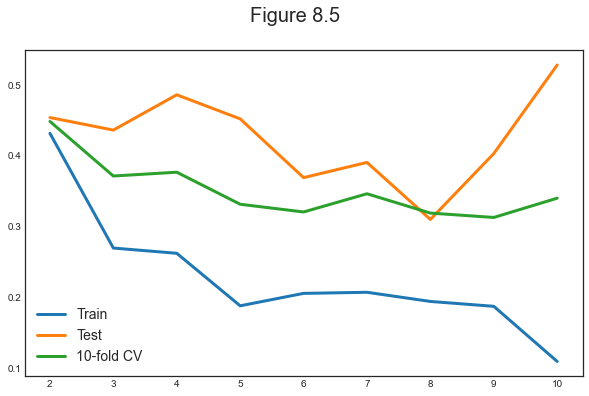

In [123]:
# Figure 8.5
fig, ax = plt.subplots(1,1,figsize=(10,6))
fig.suptitle('Figure 8.5')

# Plot scores
ax.plot(params, scores);
ax.legend(['Train','Test','10-fold CV']);

### Classification Trees

A classification tree is very similar to a regression tree, except that it is used to predict a qualitative response rather than a quantitative one.

For a classification tree, we predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs.

#### Building a classification tree

The task of growing a classification tree is similar to the task of growing a regression tree. However, in the classification setting, RSS cannot be used as a criterion for making the binary splits.

We define $\hat p_{mk}$ as the proportion of training observations in the $m^{th}$ region that are from the $k^{th}$ class. Possible loss functions to decide the splits are:

- the classification error rate

$$
E = 1 - \max _{k}\left(\hat{p}_{m k}\right)
$$

- the Gini index

$$
G=\sum_{k=1}^{K} \hat{p}_{m k}\left(1-\hat{p}_{m k}\right)
$$

- entropy

$$
D=-\sum_{k=1}^{K} \hat{p}_{m k} \log \hat{p}_{m k}
$$

When building a classification tree, either the Gini index or the entropy are typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity than is the classification error rate. 

For this section we will work with the `Heart` dataset on individual heart failures. We will try to use individual characteristics in order to predict heart deseases (`HD`). The varaible is binary: Yes, No.

In [12]:
# Load heart dataset
heart = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [13]:
# Fastorize variables
heart.ChestPain = pd.factorize(heart.ChestPain)[0]
heart.Thal = pd.factorize(heart.Thal)[0]

In [125]:
# Set features
features = [col for col in heart.columns if col!='AHD']
X2 = heart[features]
y2 = pd.factorize(heart.AHD)[0]

We now fit our classifier.

In [149]:
# Fit classification tree
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=11)
clf.fit(X2,y2)

DecisionTreeClassifier(max_leaf_nodes=11)

In [150]:
# Final score
clf.score(X2,y2)

0.8686868686868687

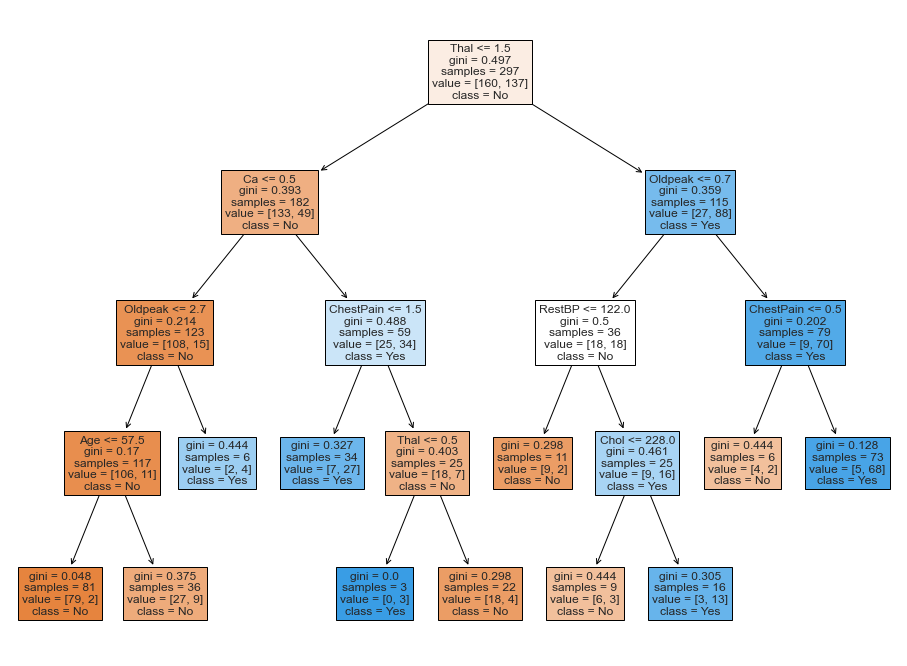

In [151]:
# Figure 8.4
fig, ax = plt.subplots(1,1, figsize=(16,12))
ax.set_title('Figure 8.4');

# Plot tree
plot_tree(clf, filled=True, feature_names=features, class_names=['No','Yes'], fontsize=12, ax=ax);

This figure has a surprising characteristic: some of the splits yield two terminal nodes that have the same predicted value. 

For instance, consider the split `Age`<=57.5 near the bottom left of the unpruned tree. Regardless of the value of `Age`, a response value of *No* is predicted for those observations. Why, then, is the split performed at all? 

The split is performed because it leads to increased node purity. That is, 2/81 of the observations corresponding to the left-hand leaf have a response value of *Yes*, whereas 9/36 of those corresponding to the right-hand leaf have a response value of *Yes*. Why is node purity important? Suppose that we have a test observation that belongs to the region given by that left-hand leaf. Then we can be pretty certain that its response value is *No*. In contrast, if a test observation belongs to the region given by the right-hand leaf, then its response value is probably *No*, but we are much less certain. Even though the split `Age`<=57.5 does not reduce the classification error, it improves the Gini index and the entropy, which are more sensitive to node purity.

#### Trees vs Regression

**Advantages**

- Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!
- Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches seen in previous chapters.
- Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small).
- Trees can easily handle qualitative predictors without the need to create dummy variables.

**Disadvantages**

- trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches seen in this book.
- trees can be very non-robust. In other words, a small change in the data can cause a large change in the final estimated tree.

## Bagging, Random Forests, Boosting

Bagging, random forests, and boosting use trees as building blocks to construct more powerful prediction models.

### Bagging

The main problem of decision trees is that they suffer from **high variance**. *Bootstrap aggregation*, or *bagging*, is a general-purpose procedure for reducing the variance of a statistical learning method.

The main idea behind *bagging* is tha,t given a set of n independent observations $Z_1,...,Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar Z$ of the observations is given by $\sigma^2/n$. In other words, averaging a set of observations reduces variance.

Indeed *bagging* consists in taking many training sets from the population, build a separate prediction model using each training set, and **average the resulting predictions**. Since we do not have access to many training sets, we resort to bootstrapping.

#### Out-of-Bag Error Estimation

It turns out that there is a very straightforward way to estimate the test error of a bagged model, without the need to perform cross-validation or the validation set approach. Recall that the key to bagging is that trees are repeatedly fit to bootstrapped subsets of the observations. One can show that on average, each bagged tree makes use of around two-thirds of the observations. The remaining one-third of the observations not used to fit a given bagged tree are referred to as the out-of-bag (OOB) observations. We can predict the response for the ith observation using each of the trees in which that observation was OOB.

We are now going to compute the Gini index for the `Heart` dataset using different numbers of trees.

In [275]:
# Init
params = range(2,50)
bagging_scores = np.zeros((len(params),2))

# Loop over parameters
for i, param in enumerate(params):
    bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=param, oob_score=True)
    bagging.fit(X2,y2)
    bagging_scores[i,0] = bagging.score(X2, y2)
    bagging_scores[i,1] = bagging.oob_score_

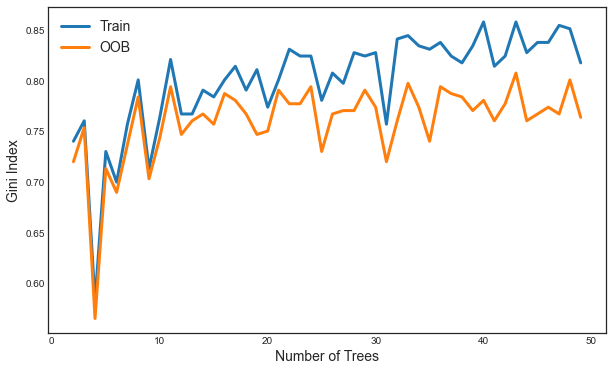

In [276]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

# Plot scores
ax.plot(params, bagging_scores);
ax.legend(['Train','OOB']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Gini Index');

It can be shown that with B sufficiently large, OOB error is virtually equivalent to leave-one-out cross-validation error. The OOB approach for estimating the test error is particularly convenient when performing bagging on large data sets for which cross-validation would be computationally onerous.

#### Variable Importance Measures

As we have discussed, the main advantage of bagging is to reduce prediction variance. However, with bagging it can be difficult to interpret the resulting model. In fact we cannot draw trees anymore given we have too many of them.

However, one can obtain an overall summary of the importance of each predictor using the RSS (for bagging regression trees) or the Gini index (for bagging classification trees). In the case of bagging regression trees, we can record the total amount that the RSS is decreased due to splits over a given predictor, averaged over all trees. A large value indicates an important predictor. Similarly, in the context of bagging classification trees, we can add up the total amount that the Gini index is decreased by splits over a given predictor, averaged over all trees.

In [277]:
# Compute feature importance
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

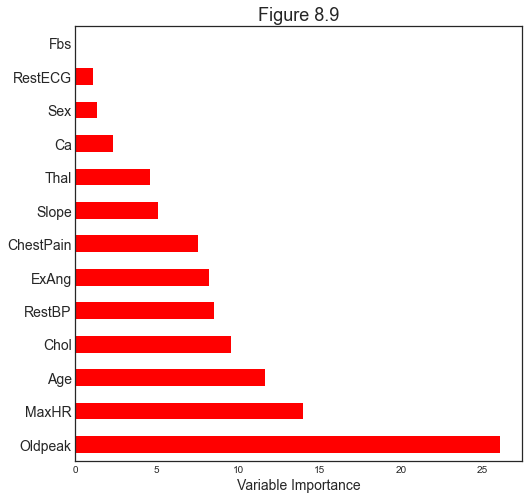

In [278]:
# Figure 8.9
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('Figure 8.9');

# Plot feature importance
h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
h1.plot(kind='barh', color='r', ax=ax)
ax.set_xlabel('Variable Importance'); 
plt.yticks(fontsize=14);
plt.gca().legend_ = None;

### Random Forests

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of m predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those m predictors. A fresh sample of m predictors is taken at each split, and typically we choose $m \sim \sqrt{p}$ — that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors

In other words, in building a random forest, at each split in the tree, the algorithm is not even allowed to consider a majority of the available predictors. This may sound crazy, but it has a clever rationale. Suppose that there is one very strong predictor in the data set, along with a number of other moderately strong predictors. Then in the collection of bagged trees, most or all of the trees will use this strong predictor in the top split. Consequently, all of the bagged trees will look quite similar to each other. Hence the predictions from the bagged trees will be highly correlated. Un- fortunately, averaging many highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities. In particular, this means that bagging will not lead to a substantial reduction in variance over a single tree in this setting.

Random forests overcome this problem by forcing each split to consider only a subset of the predictors. 

In [279]:
%%capture

# Init
forest_scores = np.zeros((len(params),2))

# Loop over parameters
for i, k in enumerate(params):
    forest = RandomForestClassifier(n_estimators=k, oob_score=True, max_features="sqrt")
    forest.fit(X2,y2)
    forest_scores[i,0] = forest.score(X2, y2)
    forest_scores[i,1] = forest.oob_score_

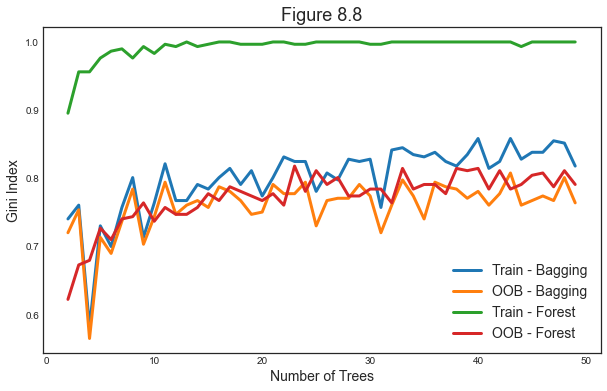

In [280]:
# Figure 8.8
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Figure 8.8');

# Plot scores
ax.plot(params, bagging_scores);
ax.plot(params, forest_scores);
ax.legend(['Train - Bagging','OOB - Bagging', 'Train - Forest','OOB - Forest']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Gini Index');

As for bagging, we can plot feature importance.

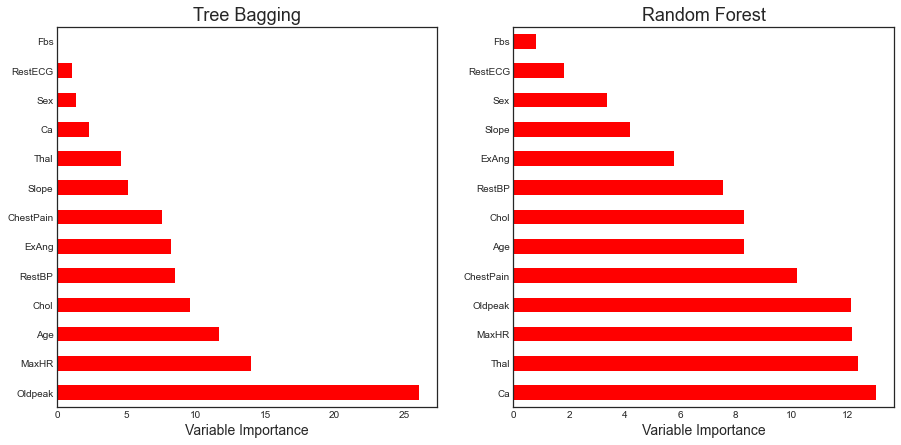

In [281]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))


# Plot feature importance - Bagging
h1.plot(kind='barh', color='r', ax=ax1)
ax1.set_xlabel('Variable Importance'); 
ax1.set_title('Tree Bagging')

# Plot feature importance
h2 = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=features)
h2 = h2.sort_values(by='Importance', axis=0, ascending=False)
h2.plot(kind='barh', color='r', ax=ax2)
ax2.set_title('Random Forest')

# All plots
for ax in fig.axes:
    ax.set_xlabel('Variable Importance'); 
    ax.legend([])

From the figure we observe that varaible importance ranking is similar with bagging and random forests, but there are significant differences.

We are now going to look at the importance of random forests using the gene dataset

In [333]:
# Load data
gene_X_train = pd.read_csv('data/Khan_xtrain.csv').iloc[:,1:501]
gene_X_test = pd.read_csv('data/Khan_xtest.csv').iloc[:,1:501]
gene_y_train = pd.read_csv('data/Khan_ytrain.csv')['x'].values
gene_y_test = pd.read_csv('data/Khan_ytest.csv')['x'].values

In [334]:
gene_X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
0,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,0.565427,...,-0.206164,-0.887460,-0.334774,-2.475749,-0.116759,-0.847231,-1.243754,-2.752002,0.394674,-1.506881
1,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,0.159053,...,-0.161226,-0.963907,-0.418702,-2.045620,-0.283292,-0.432631,-0.769812,-2.513306,-0.501205,-0.819164
2,-0.084469,-1.649739,-0.241307,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,0.496585,...,0.084892,-0.436337,-0.386251,-2.019664,-0.684187,-0.168537,-0.614891,-2.141317,-0.490696,-0.815993
3,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,0.994732,...,-0.400030,-0.113169,1.097445,-0.567749,0.948990,0.053825,0.065507,-0.995334,0.657624,-0.627921
4,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,0.278313,...,-0.543693,-0.852612,0.436059,-0.381260,-0.190918,-0.089706,-0.899925,-1.254214,0.472563,0.177225


In [338]:
# Init
params = range(50,150,10)
m_scores = np.zeros((len(params),3))
p = np.shape(gene_X_train)[1]

# Loop over parameters
for i, k in enumerate(params):
    print(i)
    
    # Array of features
    ms = [p, round(p/2), round(p**.5)]
    
    # Loop over values of m
    for j, m in enumerate(ms):
        forest = RandomForestClassifier(n_estimators=k, max_features=m)
        forest.fit(gene_X_train, gene_y_train)
        m_scores[i,j] = forest.score(gene_X_test, gene_y_test)

0
1
2
3
4
5
6
7
8
9


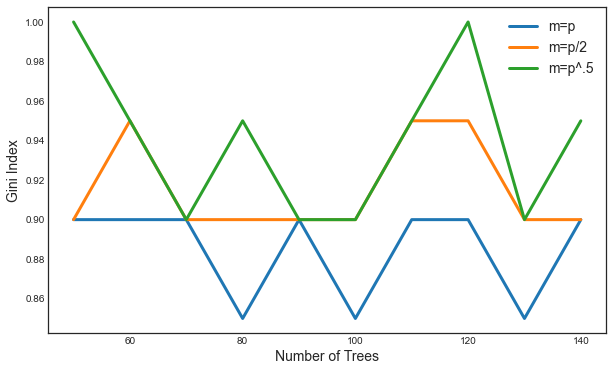

In [337]:
# Figure 8.10
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Figure 8.10');

# Plot scores
ax.plot(params, m_scores);
ax.legend(['m=p','m=p/2','m=p^.5']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

### Boosting

Like bagging, boosting is a general approach that can be applied to many statistical learning methods for regression or classification. Here we restrict our discussion of boosting to the context of decision trees.

Boosting works similarly to bagging, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

What is the idea behind this procedure? Given the current model, we fit a decision tree to the residuals from the model. That is, **we fit a tree using the current residuals**, rather than the outcome $y$, as the response. We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes, determined by the parameter $d$ in the algorithm. By fitting small trees to the residuals, **we slowly improve $\hat f$ in areas where it does not perform well**. The shrinkage parameter λ slows the process down even further, allowing more and different shaped trees to attack the resid- uals. In general, statistical learning approaches that learn slowly tend to perform well. 

#### Algorithm

The boosting algorithm works as follows:

1. Set $\hat f(x)=0$ and $r_i=y_i$ for all $i$ in the training set.
2. For $b=1,2,...,B$ repeat:
    a. Fit a tree $\hat fˆb$ with $d$ splits ($d+1$ terminal nodes) to the training data $(X,r)$.
    b. Update $\hat f$ by adding in a shrunken version of the new tree:
    $$
    \hat f(x) \leftarrow \hat f(x) + \hat f^b(x)
    $$
    c. Update the residuals
    $$
    r_i = r_i - \lambda \hat f^b(x_i)
    $$
3. Output the boosted model
$$
\hat{f}(x)=\sum_{b=1}^{B} \lambda \hat{f}^{b}(x)
$$

Boosting has three tuning parameters:

1. The number of trees B
2. The shrinkage parameter $\lambda$. This controls the rate at which boosting learns.
3. The number $d$ of splits in each tree, which controls the complexity of the boosted ensemble. Often d = 1 works well, in which case each tree is a stump, consisting of a single split.

In [342]:
# Init
params = range(50,150,10)
boost_scores = np.zeros((len(params),3))
p = np.shape(gene_X_train)[1]

# Loop over parameters
for i, k in enumerate(params):
    print(i)
    
    # First score: random forest
    forest = RandomForestClassifier(n_estimators=k, max_features="sqrt")
    forest.fit(gene_X_train, gene_y_train)
    boost_scores[i,0] = forest.score(gene_X_test, gene_y_test)
    
    # Second score: boosting with 1-split trees
    boost1 = GradientBoostingClassifier(learning_rate=0.01, max_depth=1)
    boost1.fit(gene_X_train, gene_y_train)
    boost_scores[i,1] = boost1.score(gene_X_test, gene_y_test)
    
    # Third score: boosting with 1-split trees
    boost2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=2)
    boost2.fit(gene_X_train, gene_y_train)
    boost_scores[i,2] = boost2.score(gene_X_test, gene_y_test)

0
1
2
3
4
5
6
7
8
9


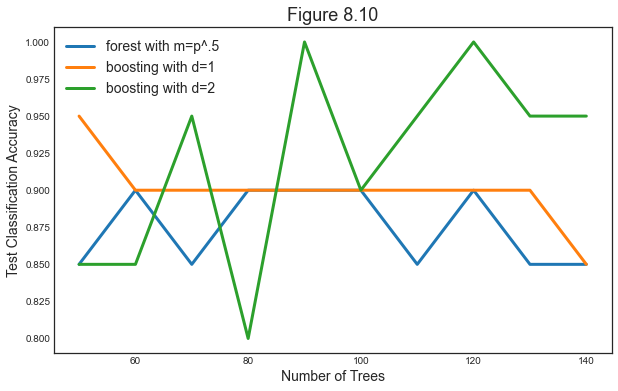

In [343]:
# Figure 8.11
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Figure 8.11');

# Plot scores
ax.plot(params, m_scores);
ax.legend(['forest with m=p^.5','boosting with d=1','boosting with d=2']);
ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

## Labs

## Lab 1: Decision Trees

### Lab1.1: Fitting Classification Trees

We'll start by using **classification trees** to analyze the `Carseats` data set. In these
data, `Sales` is a continuous variable, and so we begin by converting it to a
binary variable. We use the `ifelse()` function to create a variable, called
`High`, which takes on a value of `Yes` if the `Sales` variable exceeds 8, and
takes on a value of `No` otherwise. We'll append this onto our dataFrame using the `.map()` function, and then do a little data cleaning to tidy things up:

In [132]:
# Import dataset
carseats = pd.read_csv('data/Carseats.csv')
carseats['High'] = carseats.Sales.map(lambda x: 1 if x>8 else 0)
carseats.ShelveLoc = pd.factorize(carseats.ShelveLoc)[0]
carseats.Urban = carseats.Urban.map({'No':0, 'Yes':1})
carseats.US = carseats.US.map({'No':0, 'Yes':1})
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error rather than simply computing
the training error. We first split the observations into a training set and a test
set:

In [75]:
X = df3.drop(['Sales', 'High'], axis = 1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the `max_depth` parameter:

In [76]:
classification_tree_carseats = DecisionTreeClassifier(max_depth = 6)
classification_tree_carseats.fit(X_train, y_train)
classification_tree_carseats.score(X_train, y_train)

0.921875

We see that the training accuracy is 92.2%.

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in `sklearn`. We use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file,
and the `graphviz.Source()` function to display the image:

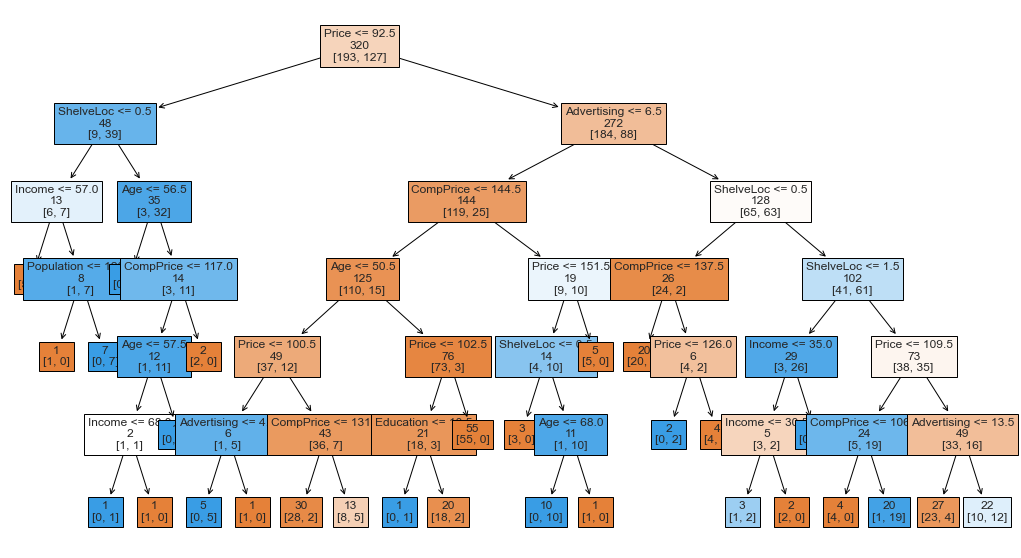

In [88]:
# Plot tree
fig, ax = plt.subplots(1,1, figsize=(18,10))

plot_tree(classification_tree_carseats, feature_names=X.columns,
          label='none', impurity=False, filled=True, fontsize=12, ax=ax);

The most important indicator of `High` sales appears to be `Price`.

Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. We can then build a confusion matrix, which shows that we are making correct predictions for
around 72.5% of the test data set:

In [89]:
pred = classification_tree_carseats.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm)
# (37+21)/80 = 0.745

     No  Yes
No   36   15
Yes   7   22


### Lab 1.2: Fitting Regression Trees

Now let's try fitting a **regression tree** to the `Boston` data set from the `MASS` library. First, we create a
training set, and fit the tree to the training data using `medv` (median home value) as our response:

In [93]:
boston_df = pd.read_csv('data/Boston.csv')
X = boston_df.drop('medv', axis = 1)
y = boston_df.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Pruning not supported. Choosing max depth 2)
regr_tree_boston = DecisionTreeRegressor(max_depth = 2)
regr_tree_boston.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

Let's take a look at the tree:

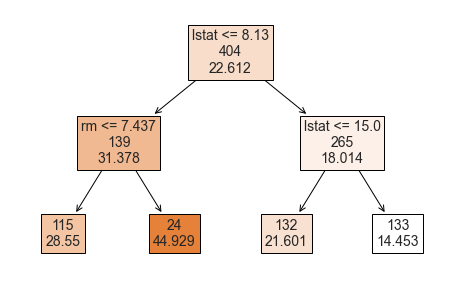

In [96]:
# Plot tree
fig, ax = plt.subplots(1,1)

plot_tree(regr_tree_boston, feature_names=X_train.columns,
          label='none', impurity=False, filled=True, fontsize=14, ax=ax);

The variable `lstat` measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of `lstat` correspond
to more expensive houses. The tree predicts a median house price
of \$45,766 for larger homes (`rm>=7.4351`) in suburbs in which residents have high socioeconomic
status (`lstat<7.81`).

Now let's see how it does on the test data:

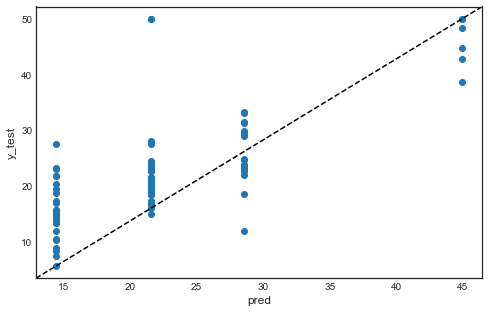

In [98]:
pred = regr_tree_boston.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred);

The test set MSE associated with the regression tree is
35.4. The square root of the MSE is therefore around 5.95, indicating
that this model leads to test predictions that are within around \$5,950 of
the true median home value for the suburb.
 

   
### 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `python` and the version of the `RandomForestRegressor` package
installed on your computer, so don't stress out if you don't match up exactly with the book. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [99]:
# Bagging: using all features
bagged_boston = RandomForestRegressor(max_features = 13, random_state = 1)
bagged_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

The argument `max_features = 13` indicates that all 13 predictors should be considered
for each split of the tree -- in other words, that bagging should be done. How
well does this bagged model perform on the test set?

19.46097414705883

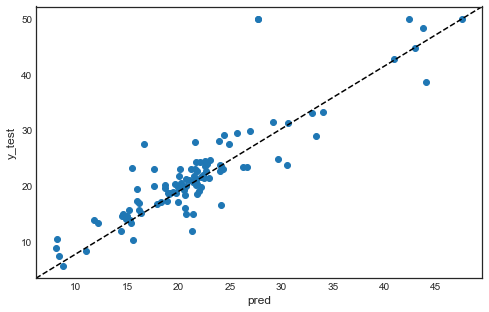

In [100]:
pred = bagged_boston.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

We can grow a random forest in exactly the same way, except that
we'll use a smaller value of the `max_features` argument. Here we'll
use `max_features = 6`:

In [101]:
# Random forests: using 6 features
random_forest_boston = RandomForestRegressor(max_features = 6, random_state = 1)

random_forest_boston.fit(X_train, y_train)

pred = random_forest_boston.predict(X_test)
mean_squared_error(y_test, pred)

22.080069764705893

The test set MSE is even lower; this indicates that random forests yielded an
improvement over bagging in this case.

Using the `feature_importances_` attribute of the `RandomForestRegressor`, we can view the importance of each
variable:

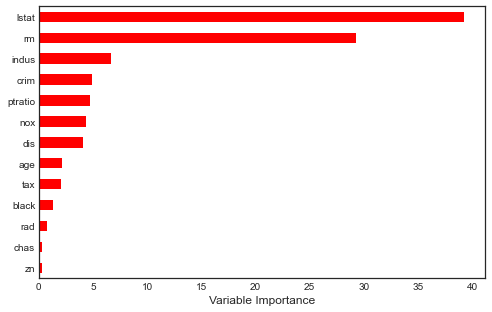

In [102]:
Importance = pd.DataFrame({'Importance':random_forest_boston.feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (`lstat`) and the house size (`rm`)
are by far the two most important variables.

### 8.3.4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree:

In [103]:
boosted_boston = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.01, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

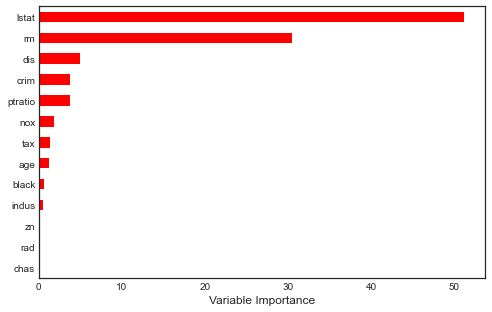

In [104]:
feature_importance = boosted_boston.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [105]:
mean_squared_error(y_test, boosted_boston.predict(X_test))

19.046377762502416

The test MSE obtained is similar to the test MSE for random forests
and superior to that for bagging. If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda = 0.2$:

In [106]:
boosted_boston2 = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.2, 
                                            max_depth = 4, 
                                            random_state = 1)
boosted_boston2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_boston2.predict(X_test))

17.667086952596446

In this case, using $\lambda = 0.2$ leads to a slightly lower test MSE than $\lambda = 0.01$.

To get credit for this lab, post your responses to the following questions:
 - What's one real-world scenario where you might try using Bagging?
 - What's one real-world scenario where you might try using Random Forests?
 - What's one real-world scenario where you might try using Boosting?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=264671

## Next Session

Jump to [Session 8 - Post-double Selection](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/8_postdoubleselection.ipynb)